In [134]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import RFE

# Data loading and exploration

In [135]:
# Import dataset
cancer_data = load_breast_cancer()

# Initialize features and target
X = cancer_data.data
y = cancer_data.target

In [136]:
# Explore Dataset
print(f"Feature Names: {cancer_data.feature_names}")
print()
print(f"Target Name: {cancer_data.target_names}")
print()

# Create dataFrame for better visualization
df = pd.DataFrame(data=np.c_[cancer_data['data'], cancer_data['target']], columns=list(cancer_data['feature_names']) + ['target'])

# Check for missing values
print(f"Missing Values: {df.isnull().sum().sum()}")

Feature Names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']

Target Name: ['malignant' 'benign']

Missing Values: 0


# Visualize Correlations

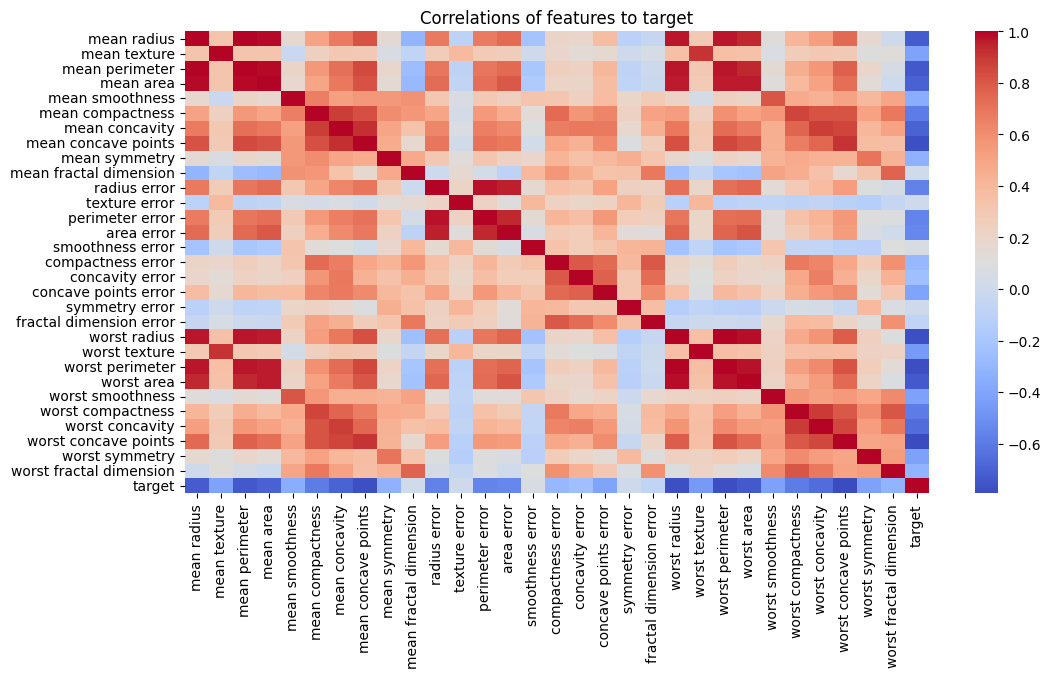

In [137]:
# Plot heatmap to visualize correlations
df_corr = df.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(df_corr, annot=False, cmap='coolwarm')
plt.title("Correlations of features to target")
plt.show()

# Feature Selection

In [138]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

# Create the Classifier
clf = DecisionTreeClassifier()
# Initialize Recursive Feature Elimination
rfe = RFE(estimator=clf, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Select features
selected_features = cancer_data['feature_names'][rfe.support_]
print(f"Selected Features: {selected_features}")

# Transform dataset to selected features
X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

Selected Features: ['mean concave points' 'area error' 'smoothness error'
 'concave points error' 'fractal dimension error' 'worst radius'
 'worst texture' 'worst perimeter' 'worst smoothness'
 'worst concave points']


# Hyperparameter Tuning with GridSearchCV

In [139]:
# create parameter grid
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [None, 10, 20, 30, 40, 50],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4]
}

# Initialize GridSearch
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy')
grid_search.fit(X_train_selected, y_train)

# Best parameters
best_clf = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print()

# Cross validation scores
cv_scores = cross_val_score(best_clf, X_train_selected, y_train, cv=5)
print(f"Cross Validation Scores: {cv_scores}")
print(f"Average CV Score: {np.mean(cv_scores)}")

# Train model
best_clf.fit(X_train_selected, y_train)

# Predict Test values
y_test_pred = best_clf.predict(X_test_selected)

Best parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}

Cross Validation Scores: [0.97802198 0.92307692 0.94505495 0.95604396 0.92307692]
Average CV Score: 0.945054945054945


# Evaluate Model

In [140]:
# Calculate Accuracy
accuracy = accuracy_score(y_test, y_test_pred)
accuracy_percentage = round(accuracy*100, 2)
print("Accuracy : " + str(accuracy_percentage) + "%")

print()

# Get classification report
clf_report = classification_report(y_test, y_test_pred, target_names=cancer_data.target_names)
print(clf_report)

Accuracy : 95.61%

              precision    recall  f1-score   support

   malignant       0.97      0.91      0.94        43
      benign       0.95      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



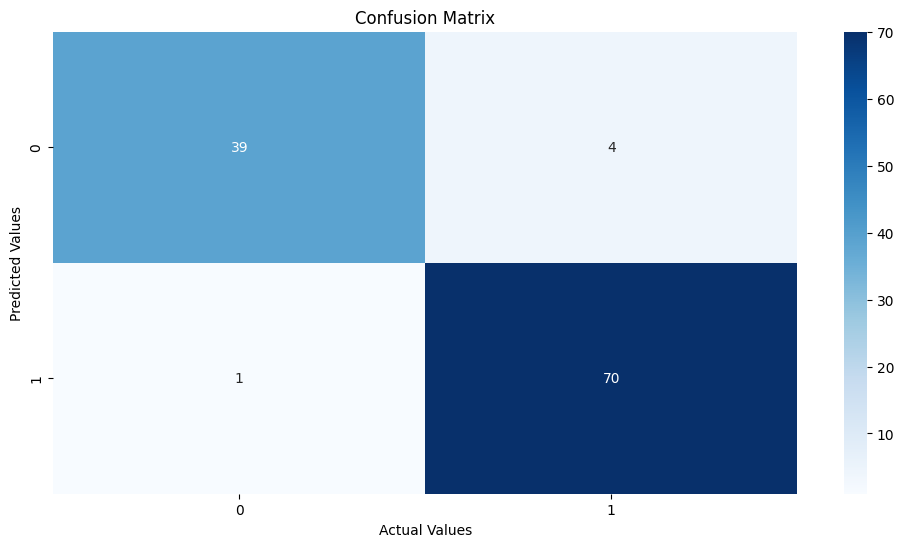

In [141]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

In [142]:
# Print importance of features
feature_importances = pd.DataFrame(best_clf.feature_importances_, index=selected_features, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                         importance
mean concave points        0.588917
worst texture              0.110206
worst perimeter            0.105379
worst radius               0.099235
worst concave points       0.022002
area error                 0.021612
concave points error       0.018594
fractal dimension error    0.017384
worst smoothness           0.010309
smoothness error           0.006362


In [143]:
# Visualize Decision Tree as text
results = export_text(best_clf, feature_names=selected_features)
print(results)

|--- mean concave points <= 0.05
|   |--- worst radius <= 16.83
|   |   |--- area error <= 48.70
|   |   |   |--- worst texture <= 30.15
|   |   |   |   |--- class: 1
|   |   |   |--- worst texture >  30.15
|   |   |   |   |--- worst radius <= 14.43
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- worst radius >  14.43
|   |   |   |   |   |--- worst smoothness <= 0.14
|   |   |   |   |   |   |--- fractal dimension error <= 0.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- fractal dimension error >  0.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- worst smoothness >  0.14
|   |   |   |   |   |   |--- class: 0
|   |   |--- area error >  48.70
|   |   |   |--- smoothness error <= 0.01
|   |   |   |   |--- class: 1
|   |   |   |--- smoothness error >  0.01
|   |   |   |   |--- class: 0
|   |--- worst radius >  16.83
|   |   |--- worst texture <= 19.91
|   |   |   |--- class: 1
|   |   |--- worst texture >  19.91
|   |   |   |--- concav

# Visualize Results

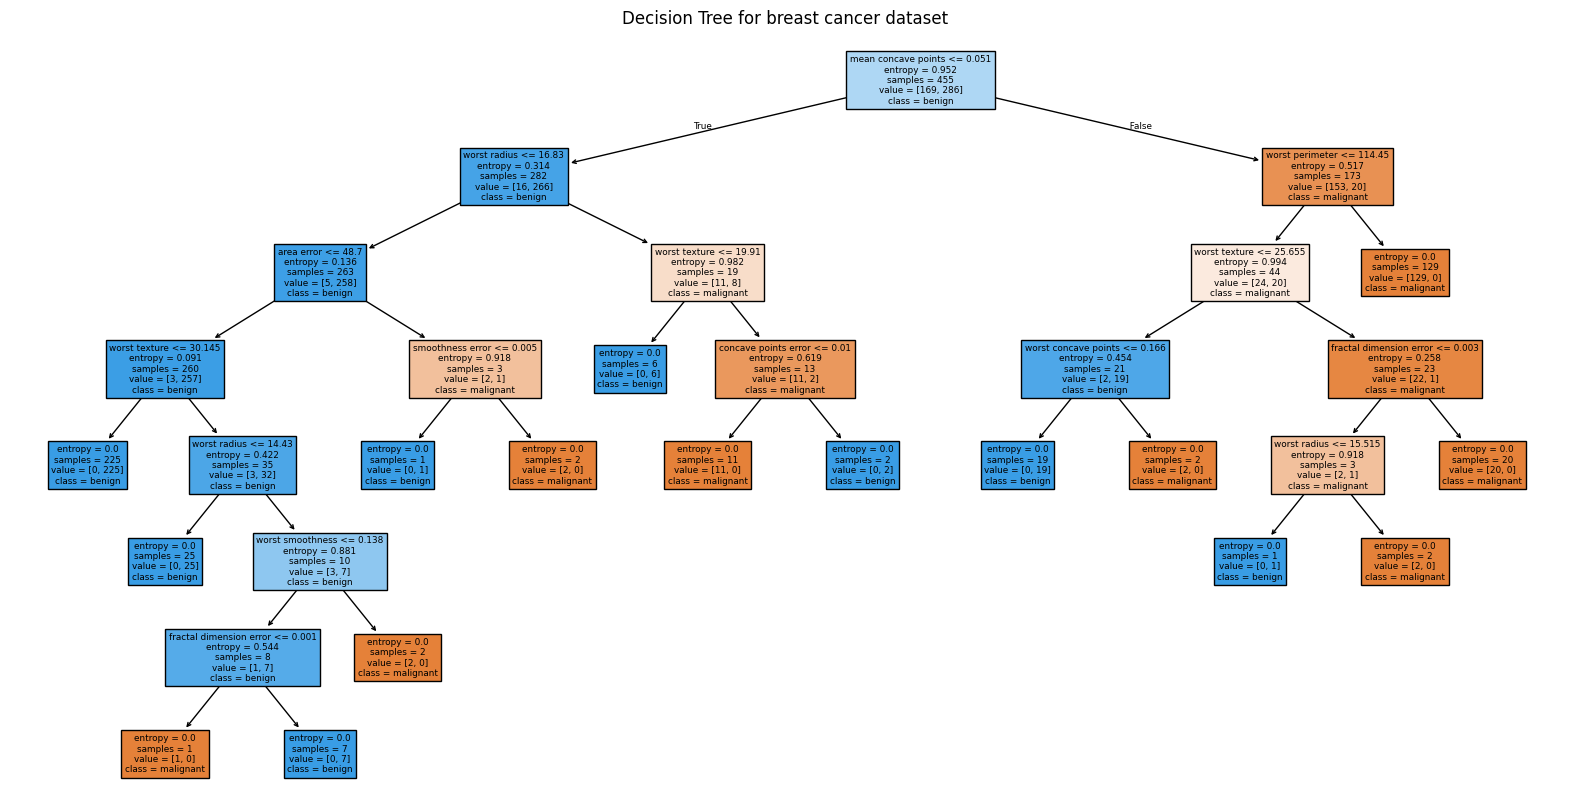

In [144]:
# Visualize tree
plt.figure(figsize=(20, 10))
plot_tree(best_clf, feature_names=selected_features, class_names=cancer_data['target_names'], filled=True)
plt.title("Decision Tree for breast cancer dataset")
plt.show()